# Appendix I

## HW3 - Analyzing Cell Cluster Data With Random Forest

### By Alexander Pena

#### Assisted by: Ted

# Library imports

In [1]:
import os
import warnings
from IPython import display
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# Data

## Data Import

First will look at the e1_positive.csv dataset

In [2]:
df = pd.read_csv("i1 positive.csv")
df

,GABRG2,CELF4,SRRM4,SLC1A3,ATP1A3,RBFOX3,GABRA4,NHSL1,GRAMD3,SEZ6L2,...,FERMT1,CSPG4,GJA1,LAMA1,YAP1,LINC00639.2,SMOC1,LINC00498,GFRA1,Label
0,35.038262,161.176004,68.074337,58.063405,20.021864,269.294069,188.205520,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.001093,0.0,0.0,0
1,95.324867,75.256474,87.297510,0.000000,18.061554,342.166102,683.328784,0.000000,0.0,1.003420,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.003420,0.0,0.0,0
2,220.143867,187.976727,42.219372,106.553653,0.000000,187.976727,299.556496,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,7.036562,0.000000,0.0,0.0,0
3,166.010840,26.159284,61.373704,0.000000,30.183789,254.549955,446.720079,0.000000,0.0,25.153158,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.006126,0.0,0.0,0
4,188.426220,71.160966,119.269788,57.129226,16.036274,265.600789,287.650666,24.054411,0.0,1.002267,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,665.606813,101.002551,4.040102,0.000000,95.952424,10.100255,79.792016,0.000000,0.0,192.914873,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.010026,0.0,0.0,0
867,21.157688,45.337903,18.135161,1.007509,290.162582,14.105125,0.000000,3.022527,0.0,64.480574,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0
868,4.111466,81.201453,1704.202638,2.055733,9.250798,75.034254,238.465025,1.027866,0.0,1.027866,...,0.0,0.0,0.0,0.0,0.0,1.027866,0.000000,0.0,0.0,0
869,37.480576,438.624037,0.000000,0.000000,69.896209,3.038966,66.857244,0.000000,0.0,130.675522,...,0.0,0.0,0.0,0.0,0.0,0.000000,252.234146,0.0,0.0,0


## Dataset Characteristics

All the samples in the dataset are numeric

### Number of samples 

In [3]:
print('Number of samples:', df.shape[0])

Number of samples: 871


### Number of each label

In [4]:
print('Number of 0 labels: ', len(df[df.Label==0]))
print('Number of 1 labels: ', len(df[df.Label==1]))

Number of 0 labels:  781
Number of 1 labels:  90


### Datatype

### Range of Data

In [5]:
print('Biggest value in the dataset:', df.min().min())
print('Biggest value in the dataset:', df.max().max())
print('Mean of all the means:', df.mean().mean())
print('Standard Deviation of all the standard deviations:', df.std().std())

Biggest value in the dataset: 0.0
Biggest value in the dataset: 11405.4695
Mean of all the means: 56.448339872720446
Standard Deviation of all the standard deviations: 118.98586594987398


### How many values are just zeros?

In [6]:
vals = []
for index, row in df.iterrows():
    vals.append(row[row == 0].value_counts()[0])
num_zeroes = pd.Series(vals)
print('Mean number of zeroes between features:', num_zeroes.mean())
print('Standard Deviation of the number of zeroes between features:', num_zeroes.std())

Mean number of zeroes between features: 356.40872560275545
Standard Deviation of the number of zeroes between features: 53.02767108583817


# Hyperparameter Tuning + Cross Validation

The hyperparameters in the random forest model are either used to increase the predictive power of the model or to make the model faster. 

| Hyperparameter    | Description
|-------------------|:----------
| n_estimators      | number of trees in the forest 
| max_features      | Sets the number of features to select when bootstrapping
| Bootstrap         | Bootstrap=True (default) samples are drawn with replacement 
| random_state      | generated random numbers for the random forest.

#### Shuffling and Splitting to x and y

In [7]:
from sklearn.utils import shuffle
df = shuffle(df)

x = df.drop('Label', axis=1)
y = df['Label']

In [8]:
grid_ranges = {
    'n_estimators': [500, 1000],
    'max_features': np.arange(1, 5, 1),
    'bootstrap': [True],
    #'random_state': [1]
}
gscv = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=grid_ranges,
    cv=3,
    n_jobs=-1,
    verbose=1,
)
gscv_fit = gscv.fit(x, y)
best_parameters = gscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'bootstrap': True, 'max_features': 3, 'n_estimators': 500}


# Create the Random Forest Model with the best found hyperparameters

In [9]:
model = RandomForestClassifier(
    n_estimators=best_parameters['n_estimators'],
    max_features=best_parameters['max_features'],
    bootstrap=best_parameters['bootstrap'],
    oob_score=True
)

# Fitting the Random Forest Model With the Entire Dataset

In [10]:
model.fit(x, y)

RandomForestClassifier(max_features=3, n_estimators=500, oob_score=True)

In [11]:
predictions = model.predict(x)

### Getting a Confusion Matrix without using Cross Validation

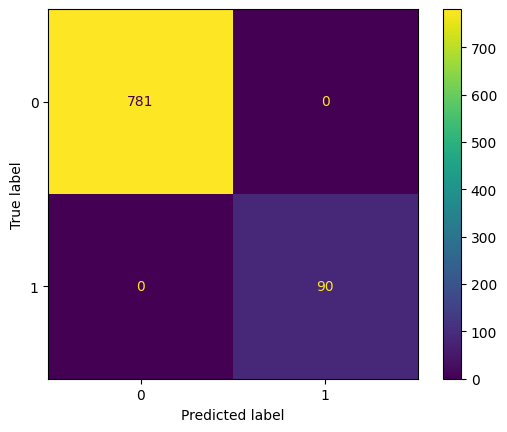

In [12]:
''' Well obviously it will predict perfectly since it was trained on it'''
cm = confusion_matrix(y, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Out of Bag Error - OOB

In [13]:
no_cv_oob = model.oob_score_
no_cv_oob

0.9724454649827784

# Now let us use Cross Validation to Split the dataset and train with 3-fold CV

In [14]:
### First split the data 3 ways

In [15]:
''' First split the data 3 ways '''

first_third = df.iloc[:df.shape[0]//3]
second_third = df.iloc[df.shape[0]//3 : 2*df.shape[0]//3]
third_third = df.iloc[df.shape[0]//3*2 : ]
print('Checking to make sure all thirds add up to the total')
print('sum of thirds', first_third.shape[0] + second_third.shape[0] + third_third.shape[0])
print('total', df.shape[0])

Checking to make sure all thirds add up to the total
sum of thirds 871
total 871


## First CV

### Trainning on first Two-folds

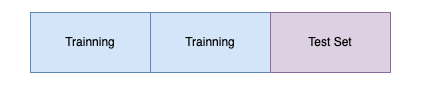

In [16]:
display.Image('./first_fold.png')

In [17]:
''' Trainning on First Two Folds '''
x_train = pd.concat([first_third, second_third]).drop('Label', axis=1)
y_train = pd.concat([first_third, second_third])['Label']
model.fit(x_train , y_train)

RandomForestClassifier(max_features=3, n_estimators=500, oob_score=True)

### Testing on 3rd Fold

In [18]:
first_predictions = model.predict(third_third.drop('Label', axis=1))

#### Matrix on first CV

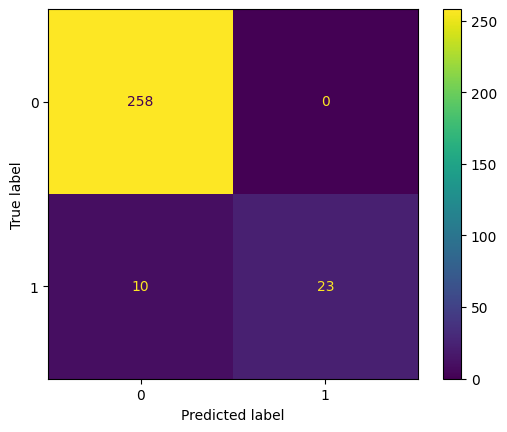

In [19]:
cm = confusion_matrix(third_third['Label'], first_predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

#### Metrics

In [20]:
first_accuracy_score = accuracy_score(first_predictions, third_third['Label'])
print('Accuracy Score', first_accuracy_score)

Accuracy Score 0.9656357388316151


#### Out of Bag Error

In [21]:
first_oob = model.oob_score_
first_oob

0.9706896551724138

## Second CV

### Trainning on first and third fold

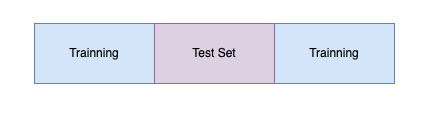

In [22]:
display.Image('./second_cv.png')

In [23]:
''' Trainning on First and Third Folds '''
x_train = pd.concat([first_third, third_third]).drop('Label', axis=1)
y_train = pd.concat([first_third, third_third])['Label']
model.fit(x_train, y_train) # refitting actually untrains previous fit

RandomForestClassifier(max_features=3, n_estimators=500, oob_score=True)

### Testing on 2nd Fold

In [24]:
second_predictions = model.predict(second_third.drop('Label', axis=1))

### Metrics

#### Confusion Matrix

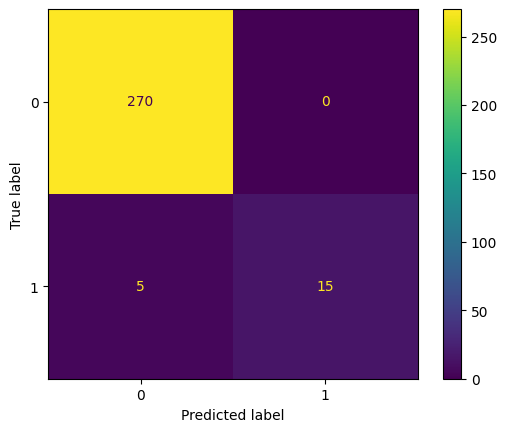

In [25]:
cm = confusion_matrix(second_third['Label'], second_predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [26]:
second_accuracy_score = accuracy_score(second_predictions, second_third['Label'])
print('accuracy_score', second_accuracy_score)

accuracy_score 0.9827586206896551


#### Out of Bag Error

In [27]:
second_oob = model.oob_score_
second_oob_eeror = 1 - second_oob
print('The oob score is:', second_oob)
print('The OOB error is:', second_oob_eeror)

The oob score is: 0.9690189328743546
The OOB error is: 0.030981067125645412


## Third CV

### Trainning on second and third fold

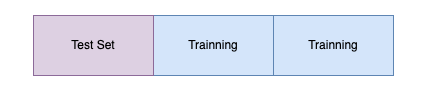

In [28]:
display.Image('./third_cv.png')

In [29]:
''' Trainning on last Two Folds '''
x_train = pd.concat([second_third, third_third]).drop('Label', axis=1)
y_train = pd.concat([second_third, third_third])['Label']
model.fit(x_train , y_train)

RandomForestClassifier(max_features=3, n_estimators=500, oob_score=True)

### Testing on 1st Fold

In [56]:
third_predictions = model.predict(first_third.drop('Label', axis=1))
third_predictions

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

#### Confusion Matrix

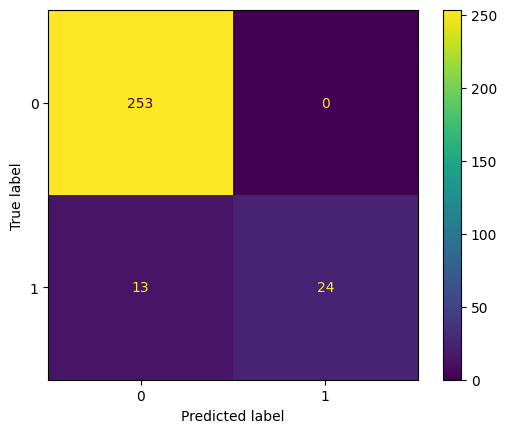

In [31]:
cm = confusion_matrix(first_third['Label'], third_predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

#### Metrics

In [32]:
third_accuracy_score = accuracy_score(third_predictions, first_third['Label'])
print('Accuracy Score', third_accuracy_score)

Accuracy Score 0.9551724137931035


In [33]:
third_oob = model.oob_score_
third_oob

0.963855421686747

## Metrics of all Three folds

### Average Accuracy Score

In [34]:
average_accuracy = (first_accuracy_score + second_accuracy_score + third_accuracy_score)/3
print('Average Accuracy', average_accuracy)

Average Accuracy 0.9678555911047914


### Average OOB Score vs No CV OOB Score

In [35]:
average_oob = (first_oob + second_oob + third_oob)/3
print('Average oob of all 3 folds:', average_oob)
print('Average oob when trained on entire dataset:', no_cv_oob)
print('Wow! They are exactly the same! This shows that RF has built in CV')

Average oob of all 3 folds: 0.9678546699111719
Average oob when trained on entire dataset: 0.9724454649827784
Wow! They are exactly the same! This shows that RF has built in CV


# Switching to train test split data

# splitting data into features and labels
### Dropping the labels for our feature matrix

In [36]:
y = df.iloc[:, df.shape[1] - 1].values
x = df.drop(['Label'], axis=1)

# Split the data into trainning set and testing set

In [37]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.25,
    #random_state=0
    shuffle=True
)

In [38]:
''' Fitting the model with split data '''
model.fit(x_train, y_train)

RandomForestClassifier(max_features=3, n_estimators=500, oob_score=True)

# Now running the model on the test split data

### Running model on entire testing data

In [39]:
predict = model.predict(x_test)

### Taking a single positive and negative sample

#### Negative Sample

In [40]:
index = 0 # index of sample to predict
single_sample = [x_test.iloc[index].to_numpy()]


In [41]:
%%time
with warnings.catch_warnings(record=True):
    single_predict = model.predict(single_sample)

CPU times: user 48.8 ms, sys: 1.95 ms, total: 50.7 ms
Wall time: 62.1 ms


In [42]:
print('predicted:', single_predict[0], ' actual', y_test[index])

predicted: 0  actual 0


#### Positive Sample

In [43]:
index = 1 # index of sample to predict
single_sample = [x_test.iloc[index].to_numpy()]

In [44]:
%%time
with warnings.catch_warnings(record=True):
    single_predict = model.predict(single_sample)

CPU times: user 50.4 ms, sys: 3.26 ms, total: 53.7 ms
Wall time: 56 ms


In [45]:
print('predicted:', single_predict[0], ' actual', y_test[index])

predicted: 0  actual 0


In [46]:
#predict = model.predict(x_test.iloc[0])
x_test.shape

(218, 608)

# Cut Off
- Change the cutoff from anyhwere to 0 and 1
- The model should be already trained and is the variable 'model'
- The default value is 0.5

In [47]:
cutoff = 0.5
y_pred_threshold = (model.predict_proba(x_test)[:, 1] > cutoff).astype('float')

# Confusion Matrix of the results with change in cutoff
confusion_matrix(y_test, y_pred_threshold)

array([[197,   0],
       [  4,  17]])

In [48]:
model.predict_proba(x_test)[0:10] # proportion of votes for each sample

array([[0.998, 0.002],
       [0.966, 0.034],
       [0.998, 0.002],
       [0.98 , 0.02 ],
       [0.996, 0.004],
       [0.994, 0.006],
       [0.874, 0.126],
       [0.978, 0.022],
       [0.99 , 0.01 ],
       [0.898, 0.102]])

# Metrics

### Confusion Matrix

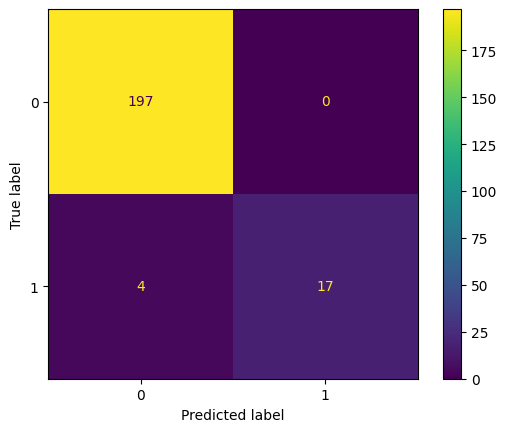

In [49]:
cm = confusion_matrix(y_test, predict, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Accuracy

In [50]:
ac = accuracy_score(predict, y_test)
print('Accuracy is:', ac)

Accuracy is: 0.981651376146789


### Classification

Report, precision, recall, f1-score, support, accuracy

In [51]:
from sklearn.metrics import classification_report
labels = ['class 0', 'class 1']
print(classification_report(y_test, predict, target_names=labels))

              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99       197
     class 1       1.00      0.81      0.89        21

    accuracy                           0.98       218
   macro avg       0.99      0.90      0.94       218
weighted avg       0.98      0.98      0.98       218



### The out of bag error, OOB

In [52]:
print('The out of bag error is', model.oob_score_)

The out of bag error is 0.9693721286370597


### Feature Ranking

In [53]:
''' First extracting feature rankings and standardizing '''
# Get importances
importances = model.feature_importances_
# Standardize Importances
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = list(x_train.columns)
features_dict = {key: val for key, val in zip(feature_names, std)}
feature_rankings = {k: v for k, v in sorted(features_dict.items(), key=lambda item: item[1], reverse=True)}
feature_rankings_list = list(feature_rankings.items())

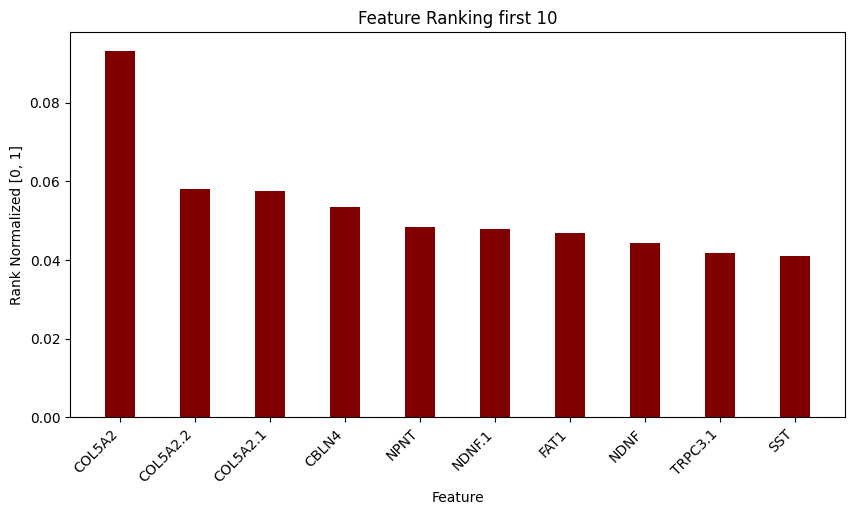

In [54]:
import matplotlib.pyplot as plt

# number of features to compare

n = 10
target_features = feature_rankings_list[:n]
feature_names = [tup[0] for tup in target_features]
feature_values = [tup[1] for tup in target_features]

fig = plt.figure(figsize = (10, 5))

plt.xticks(rotation=45, ha='right')

# creating the bar plot
plt.bar(feature_names, feature_values, color ='maroon',
        width = 0.4)

plt.xlabel('Feature')
plt.ylabel('Rank Normalized [0, 1]')
plt.title(f'Feature Ranking first {n}')

plt.show()
           

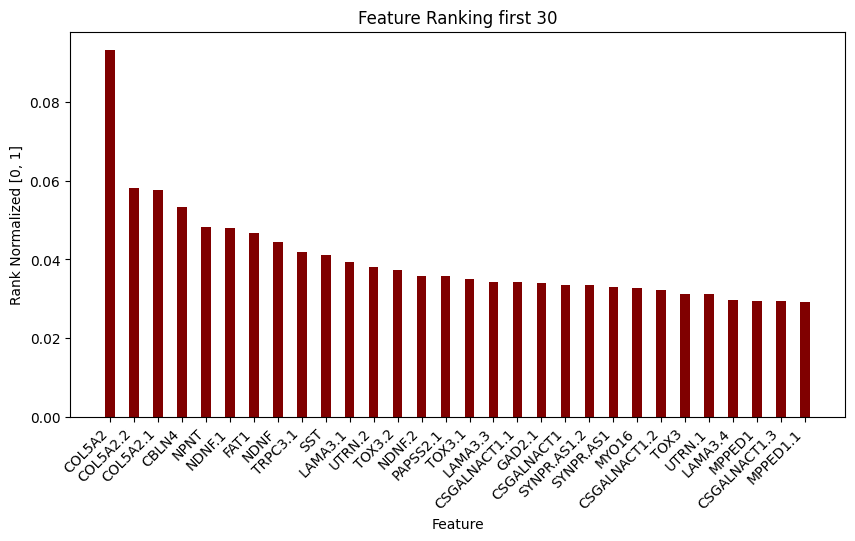

In [55]:
import matplotlib.pyplot as plt

# number of features to compare

n = 30
target_features = feature_rankings_list[:n]
feature_names = [tup[0] for tup in target_features]
feature_values = [tup[1] for tup in target_features]

fig = plt.figure(figsize = (10, 5))

plt.xticks(rotation=45, ha='right')

# creating the bar plot
plt.bar(feature_names, feature_values, color ='maroon',
        width = 0.4)

plt.xlabel('Feature')
plt.ylabel('Rank Normalized [0, 1]')
plt.title(f'Feature Ranking first {n}')

plt.show()
           